### Advanced Machine Learning

# Home Exercise #2

Assignment Due: 18/04/21 23:59

Jonathan Schler

In [1]:
student1Name="Alexander Kruglyak" # student1 name here
student1ID="323637736" # student1 ID here


student2Name="Sofya Zubtsovsky" # student2 name here
student2ID="337839112" # student2 ID here


The goal of this homework is to provide a realistic setting for a machine learning task. Therefore instructions will not specify the exact steps to carry out. Instead, it is part of theassignment to identify promising features, models and preprocessing methods and apply themas appropriate.

The overall goal is to predict whether a specific credit card transaction is fraudulent or not. Please use the data from this dataset provided on Kaggle here:https://www.kaggle.com/kartik2112/fraud-detection. The Kaggle page also contains a description of the dataset. You will use the train set for training the model and test set for validation.

You are free to manipulate the train dataset as you think is appropriate. You do not have to use the wholedataset, you can subsample if you want. While the modelling process is likely iterative, please lay out the  following tasks in the given order to facilitate grading.

In [136]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

%matplotlib inline

In [3]:
COLUMNS_TO_DROP = [
#     "Unnamed: 0",
#     "trans_num",
#     "trans_date_trans_time", # TODO: we need to split it to bins of day
    
#     "first", "last", # TODO: we can think to identify nationality by name
] 

def get_continuous_features(df):
    return df.select_dtypes(exclude=['object'])

def get_categorical_features(df):
    return df.select_dtypes(include=['object'])

def read_test_data():
    return drop_columns(read_data("fraudTest.csv"), COLUMNS_TO_DROP)

def read_data(file_name):
    return pd.read_csv(file_name)

def drop_columns(df, columns):
    return df.copy().drop(columns, axis=1)

In [4]:
features_description = {
}

title_font = {
        'color':  'darkblue',
        'weight': 'normal',
        'size': 20,
        }
labels_font = {
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

In [61]:
#### trans_date_trans_time to trans_date_category ####

def get_hour_as_category(hour):
        day_time_category = "night"
        
        if 6 <= hour and hour < 12: 
            day_time_category = "morning"
        elif hour >=12 and hour < 18:
            day_time_category = "afternoon"
        elif hour >= 18 and hour < 22:
            day_time_category = "evening"
            
        return day_time_category

def convert_to_categorical_trans_date(df):
    _df = df.copy()
    trans_date_category_list = []
    
    for  i, d in enumerate(get_categorical_features(_df).trans_date_trans_time):
        day_of_week = datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S').strftime('%A');
        hour = datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S').hour
        trans_date_category = "{}_{}".format(day_of_week, hour)
        trans_date_category_list.append(trans_date_category)
    
    _df['trans_date_category'] = trans_date_category_list
    return _df

def convert_to_categorical_trans_date_and_drop(df):
    converted_df = convert_to_categorical_trans_date(df)
    return drop_columns(converted_df, ["trans_date_trans_time"])

In [62]:
#### city_pop to city_pop_category ####

def population_as_category(p):
    category = "2M+"
    
    if p <= 100:
        category = "100-"
    elif p <= 500:
        category = "500-"
    elif p <= 1000:
        category = "1K-"
    elif p <= 2000:
        category = "2K-"
    elif p <= 3000:
        category = "3K-"
    elif p <= 5000:
        category = "5K-"
    elif p <= 10000:
        category = "10K-"
    elif p <= 30000:
        category = "30K-"
    elif p <= 50000:
        category = "50K-"
    elif p <= 100000:
        category = "100K-"
    elif p <= 200000:
        category = "200K-"
    elif p <= 500000:
        category = "500K-"
    elif p <= 1000000:
        category = "1M-"
    elif p <= 1500000:
        category = "1.5M-"
    elif p <= 2000000:
        category = "2M-"
        
    return category

def convert_to_categorical_city_pop(df):
    _df = df.copy()
    city_pop_category_list = []
    
    for p in df.city_pop:
        category = population_as_category(p)
        city_pop_category_list.append(category)
        
    _df['city_pop_category'] = city_pop_category_list
    return _df

In [82]:
def convert_cc_to_cc_type(df):
    _df = df.copy()
    cc_category_list = []
    
    for cc in df.cc_num:
        cc_category_list.append(get_cc_type(cc)
        
    _df['cc_type'] = cc_category_list
    return _df

def get_cc_type(cc_number):
    cc_number = "2703186189652095"
#     if is_american_express(cc_number): return 'AMEX'
#     if is_visa(cc_number): return 'VISA'
#     if is_mastercard(cc_number): return 'MasterCard'
#     if is_discover(cc_number): return 'Discover'
#     if is_jcb(cc_number): return 'JCB'
#     if is_diners_club(cc_number): return 'DinersClub'
#     if is_laser(cc_number): return 'Laser'
#     if is_maestro(cc_number): return 'Maestro'
#     if is_visa_electron(cc_number): return 'VisaElectron'
#     if is_total_rewards_visa(cc_number): return 'TotalRewardsVisa'
#     if is_diners_club_carte_blanche(cc_number): return 'DinersClubCarteBlanche'
#     if is_diners_club_carte_international(cc_number): return 'DinersClubCarteInt'
    
    return 'unknown'

def is_american_express(cc_number):
    """Checks if the card is an american express. If us billing address country code, & is_amex, use vpos
    https://en.wikipedia.org/wiki/Bank_card_number#cite_note-GenCardFeatures-3
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^3[47][0-9]{13}$', cc_number))


def is_visa(cc_number):
    """Checks if the card is a visa, begins with 4 and 12 or 15 additional digits.
    :param cc_number: unicode card number
    """

    # Standard Visa is 13 or 16, debit can be 19
    if bool(re.match(r'^4', cc_number)) and len(cc_number) in [13, 16, 19]:
        return True

    return False


def is_mastercard(cc_number):
    """Checks if the card is a mastercard. Begins with 51-55 or 2221-2720 and 16 in length.
    :param cc_number: unicode card number
    """
    if len(cc_number) == 16 and cc_number.isdigit():  # Check digit, before cast to int
        return bool(re.match(r'^5[1-5]', cc_number)) or int(cc_number[:4]) in range(2221, 2721)
    return False


def is_discover(cc_number):
    """Checks if the card is discover, re would be too hard to maintain. Not a supported card.
    :param cc_number: unicode card number
    """
    if len(cc_number) == 16:
        try:
            # return bool(cc_number[:4] == '6011' or cc_number[:2] == '65' or cc_number[:6] in range(622126, 622926))
            return bool(cc_number[:4] == '6011' or cc_number[:2] == '65' or 622126 <= int(cc_number[:6]) <= 622925)
        except ValueError:
            return False
    return False


def is_jcb(cc_number):
    """Checks if the card is a jcb. Not a supported card.
    :param cc_number: unicode card number
    """
    # return bool(re.match(r'^(?:2131|1800|35\d{3})\d{11}$', cc_number))  # wikipedia
    return bool(re.match(r'^35(2[89]|[3-8][0-9])[0-9]{12}$', cc_number))  # PawelDecowski


def is_diners_club(cc_number):
    """Checks if the card is a diners club. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^3(?:0[0-6]|[68][0-9])[0-9]{11}$', cc_number))  # 0-5 = carte blance, 6 = international


def is_laser(cc_number):
    """Checks if the card is laser. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^(6304|670[69]|6771)', cc_number))


def is_maestro(cc_number):
    """Checks if the card is maestro. Not a supported card.
    :param cc_number: unicode card number
    """
    possible_lengths = [12, 13, 14, 15, 16, 17, 18, 19]
    return bool(re.match(r'^(50|5[6-9]|6[0-9])', cc_number)) and len(cc_number) in possible_lengths


# Child cards

def is_visa_electron(cc_number):
    """Child of visa. Checks if the card is a visa electron. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^(4026|417500|4508|4844|491(3|7))', cc_number)) and len(cc_number) == 16


def is_total_rewards_visa(cc_number):
    """Child of visa. Checks if the card is a Total Rewards Visa. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^41277777[0-9]{8}$', cc_number))


def is_diners_club_carte_blanche(cc_number):
    """Child card of diners. Checks if the card is a diners club carte blance. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^30[0-5][0-9]{11}$', cc_number))  # github PawelDecowski, jquery-creditcardvalidator


def is_diners_club_carte_international(cc_number):
    """Child card of diners. Checks if the card is a diners club international. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^36[0-9]{12}$', cc_number))  # jquery-creditcardvalidator

SyntaxError: invalid syntax (<ipython-input-82-d01c3485af45>, line 8)

In [83]:
# convert_cc_to_cc_type(df_test).cc_type.value_counts()
# df_test
# convert_to_categorical_trans_date_and_drop(df_test).columns

TypeError: expected string or bytes-like object

## Task 1 Identify Features
Assemble a dataset consisting of features and target (for example in a dataframe or in two arrays X and y). What features are relevant for the prediction task? What features should be excluded because they leak the target information? Show visualizations or statistics to support your selection

In [142]:
data = drop_columns(read_data("fraudTest.csv"), ["Unnamed: 0"])

ss.fit(data.amt)
# amt_scaled = ss.transform(data.amt)
# data.amt = amt_scaled.reshape(-1, 1)

# fraud = data[data['is_fraud']==1]
# normal = data[data['is_fraud']==0]

# print(amt_scaled)

ValueError: Expected 2D array, got 1D array instead:
array=[ 2.86 29.84 41.28 ... 86.88  7.99 38.13].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


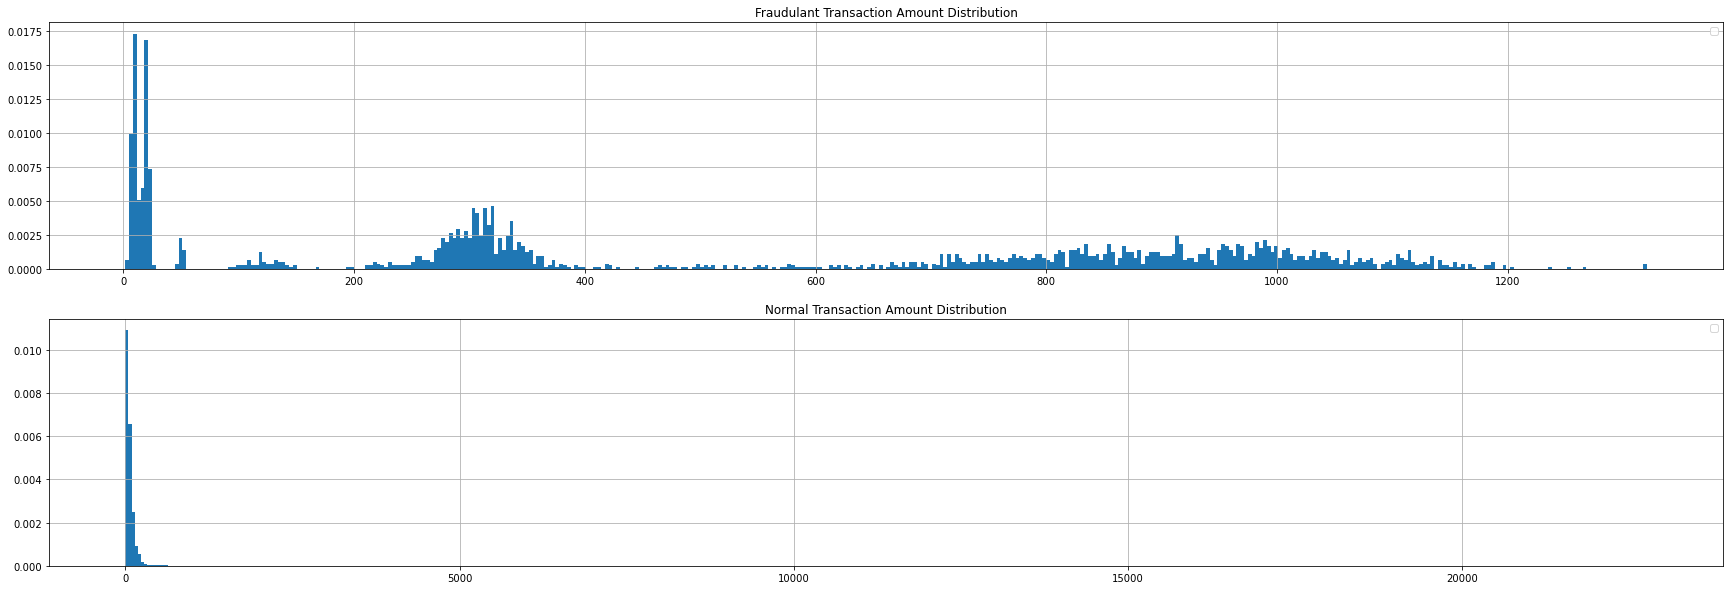

In [131]:
plt.figure(figsize=(30, 10))

print()
plt.subplot(2, 1, 1)
# subfraud = fraud[fraud.amt<500]
subfraud = fraud
subfraud.amt.hist(bins=400, density=True)
plt.title("Fraudulant Transaction Amount Distribution")
plt.legend()

plt.subplot(2, 1, 2)
# subnormal = normal[normal.amt<400]
subnormal = normal
subnormal.amt.hist(bins=500, density=True)
plt.title("Normal Transaction Amount Distribution")
plt.legend()

No handles with labels found to put in legend.


No handles with labels found to put in legend.


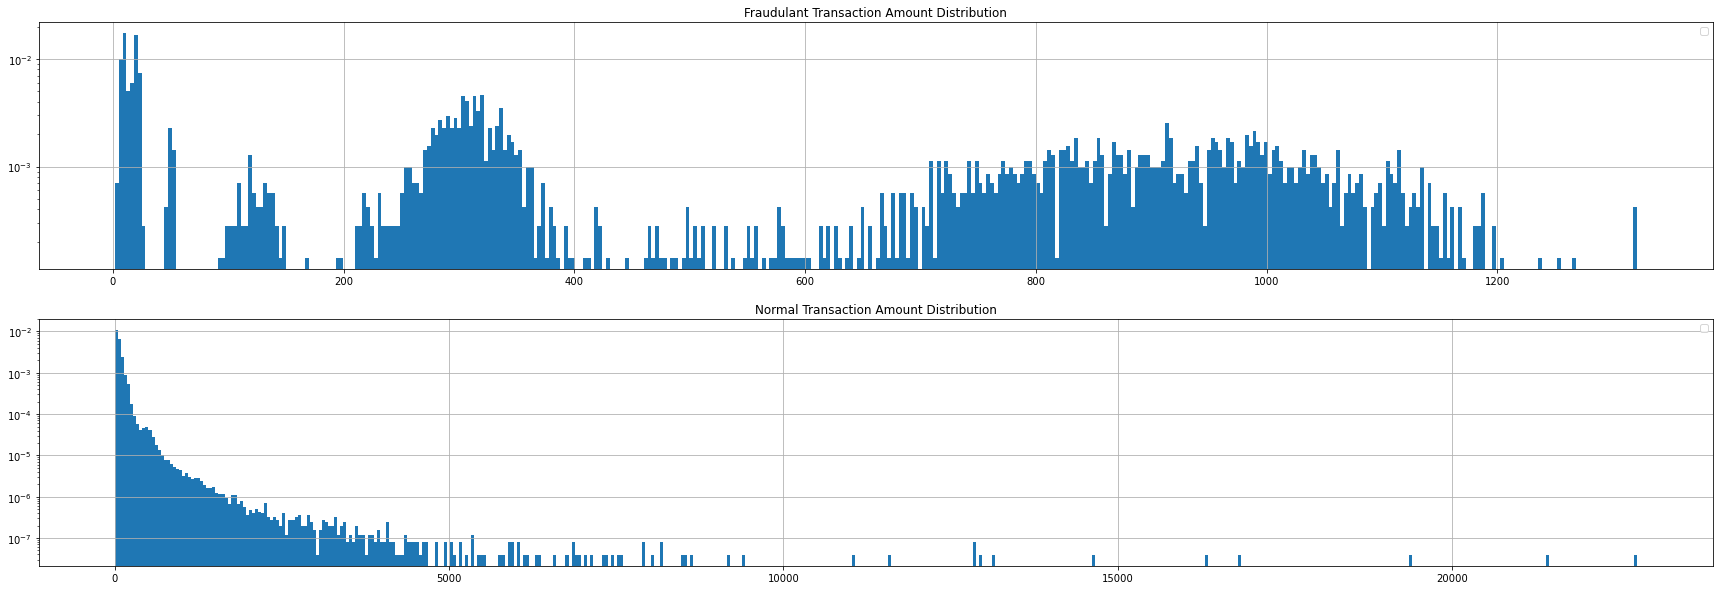

In [132]:
ss = StandardScaler()


plt.figure(figsize=(30, 10))

print()
plt.subplot(2, 1, 1)
# subfraud = fraud[fraud.amt<500]
# subfraud = fraud
scaler.fit(data.amt)
X_train_scaled = scaler.transform(fraud.amt)

fraud.amt.hist(bins=400, density=True, log=True)
plt.title("Fraudulant Transaction Amount Distribution")
plt.legend()

plt.subplot(2, 1, 2)
# subnormal = normal[normal.amt<400]
subnormal = normal
normal.amt.hist(bins=500, density=True, log=True)
plt.title("Normal Transaction Amount Distribution")
plt.legend()

<AxesSubplot:title={'center':'Correlation of Numeric Features'}>

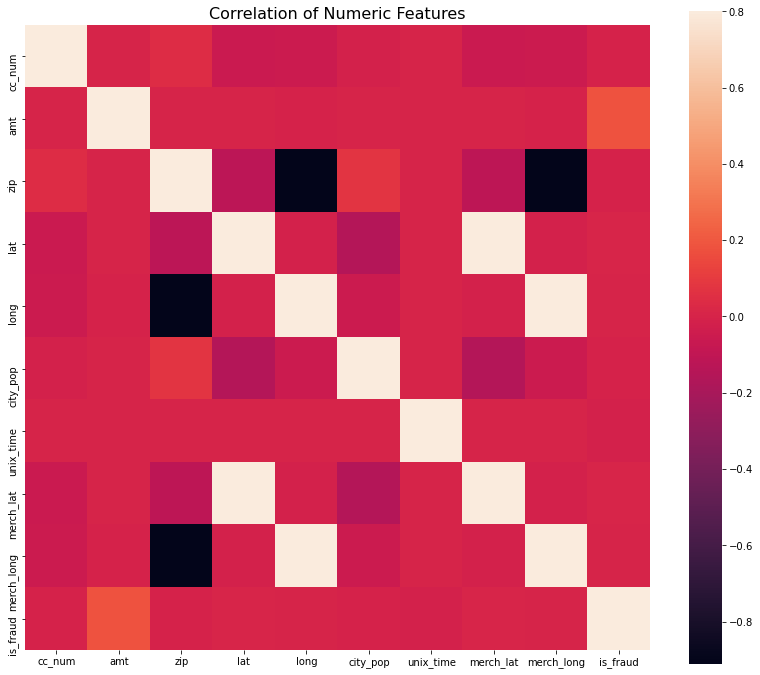

In [117]:
plt.subplots(figsize = (14,12))
plt.title('Correlation of Numeric Features',y=1,size=16)
sns.heatmap(data.corr(),square = True,  vmax=0.8)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


(0.0, 0.1)

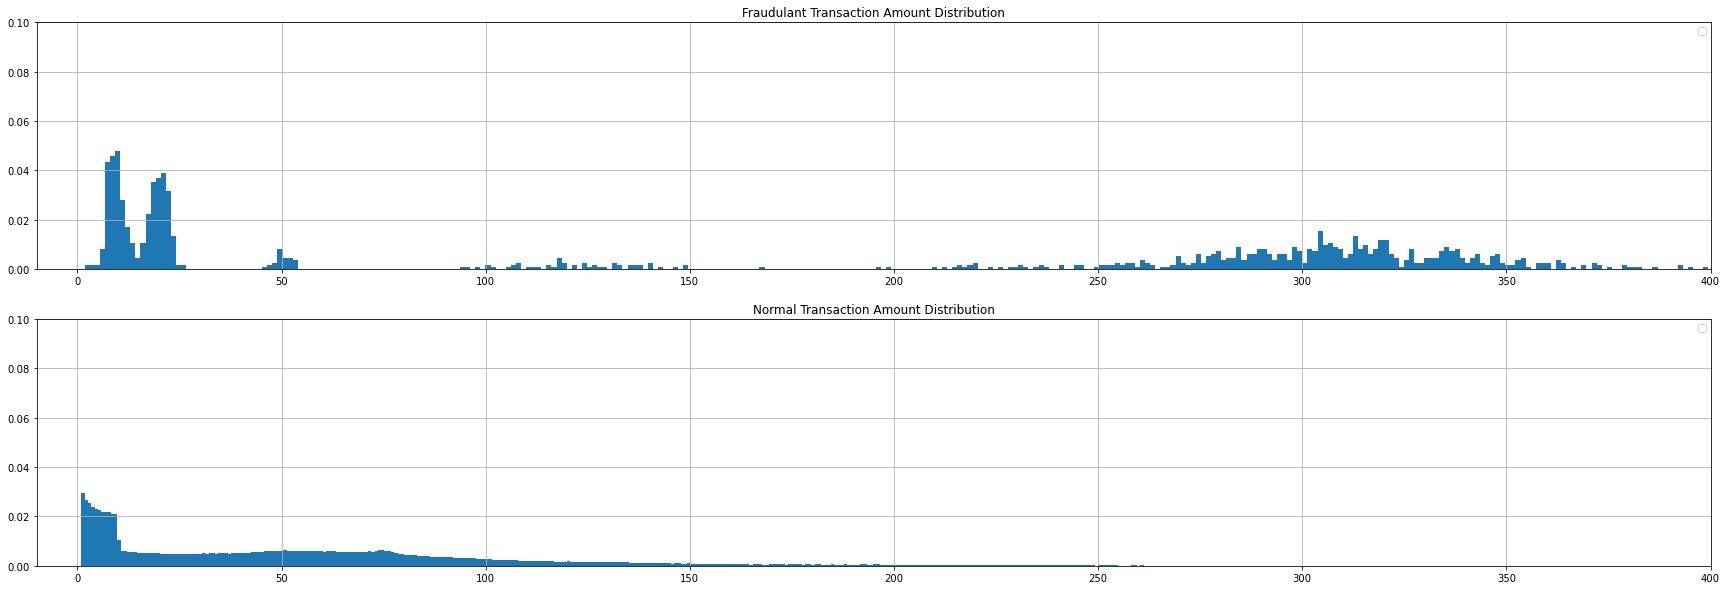

In [100]:
plt.figure(figsize=(30, 10))

print()
plt.subplot(2, 1, 1)
subfraud = fraud[fraud.amt<500]
subfraud.amt.hist(bins=400,weights=np.ones(len(subfraud.amt)) / len(subfraud.amt))
plt.title("Fraudulant Transaction Amount Distribution")
plt.legend()
plt.xlim([-10,400])
plt.ylim([0,0.1])

plt.subplot(2, 1, 2)
subnormal = normal[normal.amt<400]
subnormal.amt.hist(bins=500, weights=np.ones(len(subnormal.amt)) / len(subnormal.amt))
plt.title("Normal Transaction Amount Distribution")
plt.legend()
plt.xlim([-10,400])
plt.ylim([0,0.1])

In [98]:
df_test = read_test_data()
df_test = convert_to_categorical_trans_date_and_drop(df_test)
# get_categorical_features(df_test).columns

df_test.amt.describe()

count    555719.000000
mean         69.392810
std         156.745941
min           1.000000
25%           9.630000
50%          47.290000
75%          83.010000
max       22768.110000
Name: amt, dtype: float64

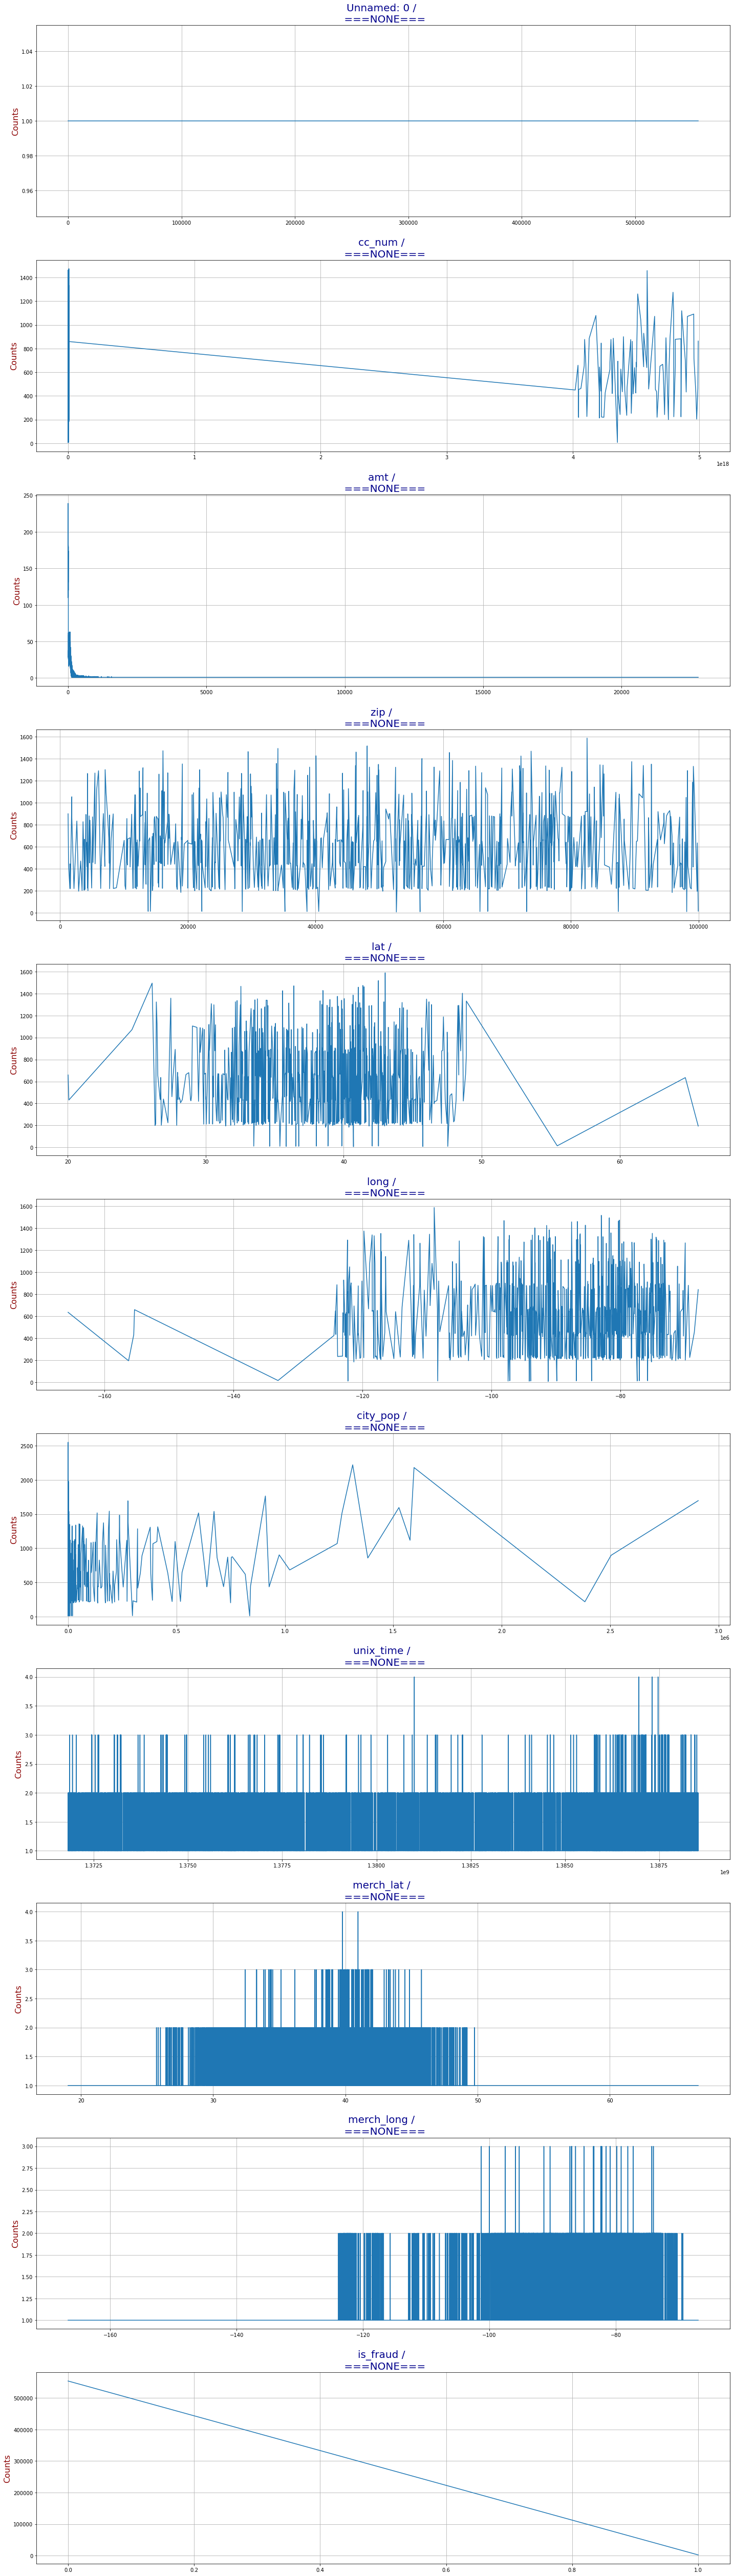

In [87]:
fig, axes = plt.subplots(11, 1, figsize=(20, 70))
continuous_features = get_continuous_features(df_test)

for i, ax in enumerate(axes.ravel()):
    feature_name = continuous_features.columns[i]
    feature_human_readable_name = features_description.get(feature_name, "===NONE===")
    y = continuous_features[feature_name].value_counts().sort_index()
    ax.set_title("{} / \n {}".format(feature_name, feature_human_readable_name), fontdict=title_font)
    ax.set_ylabel("Counts", fontdict=labels_font)
    ax.plot(y)
    ax.grid()
plt.tight_layout()

IndexError: single positional indexer is out-of-bounds

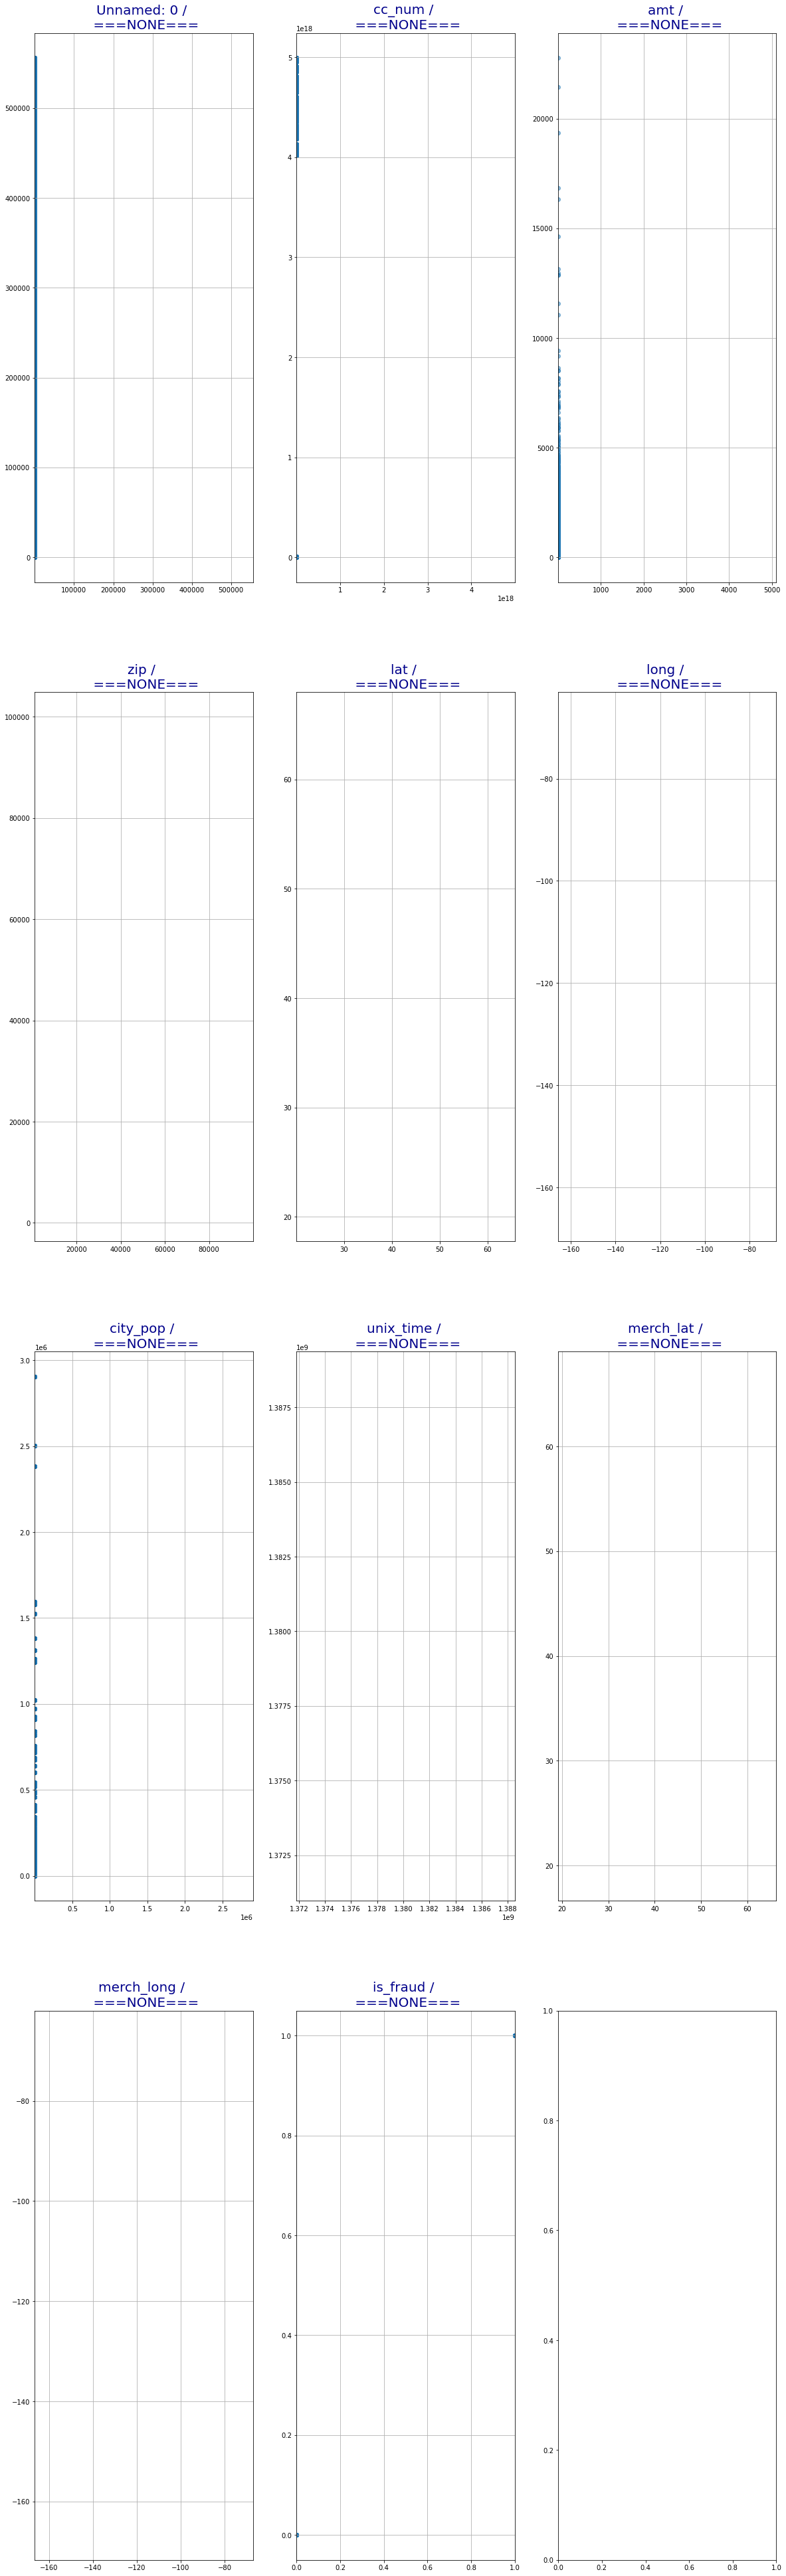

In [97]:
fig, axes = plt.subplots(4, 3, figsize=(20, 70))
x = df_test.is_fraud

for i, ax in enumerate(axes.ravel()):
    X_col = continuous_features.iloc[:, i]
#     ax.set_xlim(0, 1)
    ax.set_xlim(right=1)
    if X_col.nunique() > 10:
        ax.set_xlim(X_col.quantile(q=.0001), X_col.quantile(q=.9999))
        
    ax.scatter(x, X_col, alpha=.5)

    feature_name = continuous_features.columns[i]
    feature_human_readable_name = features_description.get(feature_name, "===NONE===")
    ax.set_title("{} / \n {}".format(feature_name, feature_human_readable_name), fontdict=title_font)
#     ax.set_ylabel("Price ($)", fontdict=labels_font)
    ax.grid()
    
plt.tight_layout()

In [ ]:
categorical_features = get_categorical_features(df_test)


fig, axes = plt.subplots(3, 3, figsize=(30,60))
for i, ax in enumerate(axes.ravel()):
    if(i >= len(categorical_features.columns)):
        break
    categorical_features.iloc[:,i].value_counts().plot(kind='bar',ax=ax,rot=45)
    ax.set_title(categorical_features.columns[i])

## Task 2 Preprocessing and Baseline Model

Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model. Feel free to generously exclude features or do simplified preprocessing for this task. As mentioned before, you don’t need to validate the model on the whole dataset

## Task 3 Feature Engineering
Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve your model? In particular, think about how to encode categorical variables.

## Task 4 Any model
Use any classification model we discussed (trees, forests, boosting, SVM) to improve your result. You can (and probably should) change your preprocessing and feature engineering to be suitable for the model. You are not required to try all of these models. Tune parameters as appropriate

## Task 5 Feature Selections
Identify features that are important for your best model. Which features are most influential,and which features could be removed without decrease in performance? Does removing irrelevant features make your model better?

## Task 6 An explainable model
Can you create an “explainable” model that is nearly as good as your best model? An explainable model should be small enough to be easily inspected - say a linear model withfew enough coefficients that you can reasonable look at all of them, or a tree with a smallnumber of leafs etc.